In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy
import scipy.stats

In [2]:
figure_path = './figures'
os.makedirs(figure_path, exist_ok=True)

In [3]:
colors = {
    # https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3
    'special_yellow': '#FFC325',
    'cb_green': '#1b9e77',
    'cb_orange': '#d95f02',
    'cb_purple': '#7570b3'
}

parameters = {
    'A': {
        'incidence': 0.25,
        'beta_counts': 10,
        'color': colors['cb_purple']
    },
}

In [4]:
score_values = np.linspace(
    0.0001,
    0.9999,
    1000
)

In [5]:
# Compute beta parameters
for key, value in parameters.items():
    parameters[key]['alpha'] = value['incidence'] * value['beta_counts']
    parameters[key]['beta'] = (1-value['incidence']) * value['beta_counts']
    
    # Compute the unconditional distribution
    parameters[key]['x'] = score_values
    parameters[key]['pdf'] = scipy.stats.beta.pdf(parameters[key]['x'], parameters[key]['alpha'], parameters[key]['beta'])
    
    # Compute the conditional distributions
    parameters[key]['pdf_1'] = parameters[key]['x']*parameters[key]['pdf'] / parameters[key]['incidence']
    parameters[key]['pdf_0'] = (1-parameters[key]['x'])*parameters[key]['pdf'] / (1-parameters[key]['incidence'])
    parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']
    
    

In [6]:
## Generate transformed versions of A with over and underestimation
parameters['A_over'] = parameters['A'].copy()
parameters['A_under'] = parameters['A'].copy()

parameters['A_under']['calibration_curve'] = -(parameters['A_under']['x']-1)**2 + 1
parameters['A_over']['calibration_curve'] = (
    2*parameters['A']['calibration_curve'] - parameters['A_under']['calibration_curve']
)

for key in ['A_over', 'A_under']:
    parameters[key]['incidence'] = scipy.integrate.cumulative_trapezoid(
        y=parameters[key]['calibration_curve']*parameters[key]['pdf'], 
        x=parameters[key]['x'],
        initial=0
    )[-1]
    parameters[key]['pdf_1'] = parameters[key]['calibration_curve']*parameters[key]['pdf'] / parameters[key]['incidence']
    parameters[key]['pdf_0'] = (1-parameters[key]['calibration_curve'])*parameters[key]['pdf'] / (1-parameters[key]['incidence'])
    

In [7]:
# Create recalibrated distributions using change of variables formula
parameters['A_under_recalib'] = parameters['A_under'].copy()
parameters['A_over_recalib'] = parameters['A_over'].copy()

parameters['A_under_recalib']['pdf'] = scipy.stats.beta.pdf(
    1-np.sqrt(1-parameters['A_under']['x']), 
    parameters['A_under']['alpha'], 
    parameters['A_under']['beta']) * np.abs(0.5*(1-parameters['A_under']['x'])**(-0.5))

parameters['A_over_recalib']['pdf'] = scipy.stats.beta.pdf(
    np.sqrt(parameters['A_over']['x']), 
    parameters['A_over']['alpha'], 
    parameters['A_over']['beta']) * np.abs(0.5*parameters['A_over']['x']**(-0.5))

for key in ['A_over_recalib', 'A_under_recalib']:
    parameters[key]['calibration_curve'] = parameters[key]['x']
    parameters[key]['pdf_1'] = parameters[key]['calibration_curve']*parameters[key]['pdf'] / parameters[key]['incidence']
    parameters[key]['pdf_0'] = (1-parameters[key]['calibration_curve'])*parameters[key]['pdf'] / (1-parameters[key]['incidence'])

In [8]:
# Create equalized odds mapped versions
parameters['A_under_recalib_eq'] = parameters['A_under_recalib'].copy()
parameters['A_over_recalib_eq'] = parameters['A_over_recalib'].copy()

for key in ['A_under_recalib_eq', 'A_over_recalib_eq']:
    parameters[key]['pdf_1'] = parameters['A']['pdf_1']
    parameters[key]['pdf_0'] = parameters['A']['pdf_0']
    parameters[key]['pdf'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) + (parameters[key]['pdf_0']*(1-parameters[key]['incidence']))
    parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']
    

In [9]:
def get_performance_metrics_group(parameter_group):
    result = {}
    result['classification_rate'] = 1-scipy.integrate.cumulative_trapezoid(
        y=parameter_group['pdf'], 
        x=parameter_group['x'],
        initial=0
    )
    result['FNR'] = scipy.integrate.cumulative_trapezoid(
        y=parameter_group['pdf_1'], 
        x=parameter_group['x'],
        initial=0
    )
    result['TPR'] = 1-result['FNR']
    result['TNR'] = scipy.integrate.cumulative_trapezoid(
        y=parameter_group['pdf_0'], 
        x=parameter_group['x'],
        initial=0
    )
    result['FPR'] = 1-result['TNR']
    return result
    
    
    return result
  
performance_metrics_dict = {key: get_performance_metrics_group(value) for key, value in parameters.items()}
for key in parameters.keys():
    parameters[key].update(performance_metrics_dict[key])

In [10]:
# Utility functions
u_tp = 0.75
u_fn = 0
u_fp = 0
u_tn = 0.25


u_pos = u_tp - u_fn
u_neg = u_tn - u_fp
threshold = u_neg / (u_pos + u_neg)

def get_conditional_utility(x):
    return (u_tp-u_fn)*x + (u_fp-u_tn)*(1-x)

for key in parameters.keys():
    parameters[key]['u_treat'] = parameters[key]['calibration_curve'] * u_tp + (1-parameters[key]['calibration_curve']) * u_fp
    parameters[key]['u_no_treat'] = parameters[key]['calibration_curve'] * u_fn + (1-parameters[key]['calibration_curve']) * u_tn
    parameters[key]['conditional_utility'] = get_conditional_utility(parameters[key]['calibration_curve'])
    parameters[key]['u_treat_integrated'] = scipy.integrate.cumulative_trapezoid(
        y=parameters[key]['u_treat']*parameters[key]['pdf'], 
        x=parameters[key]['x'],
        initial=0
    )
    parameters[key]['u_treat_integrated_complement'] = parameters[key]['u_treat_integrated'][-1] - parameters[key]['u_treat_integrated']
    parameters[key]['u_no_treat_integrated'] = scipy.integrate.cumulative_trapezoid(
        y=parameters[key]['u_no_treat']*parameters[key]['pdf'], 
        x=parameters[key]['x'],
        initial=0
    )
    parameters[key]['u_agg'] = parameters[key]['u_treat_integrated_complement'] + parameters[key]['u_no_treat_integrated']
    # Add NB, NB-fixed
    parameters[key]['nb'] = (
        parameters[key]['TPR']*parameters[key]['incidence'] - (
        parameters[key]['FPR']*(1-parameters[key]['incidence'])*parameters[key]['x']/(1-parameters[key]['x']))
    )
    parameters[key]['nb_fixed'] = (
        parameters[key]['TPR']*parameters[key]['incidence'] - (
        parameters[key]['FPR']*(1-parameters[key]['incidence'])*threshold/(1-threshold))
    )
    

In [11]:
def plot_distributions(
    parameters,
    plot_x='x', 
    plot_y='pdf', 
    ax=plt.gca(), 
    groups = None, 
    title='', 
    legend=False, 
    apply_fill=True,
    fill_min=None, 
    fill_max=None,
    threshold = None,
    calibration_curve=False,
    color_override=None,
    **kwargs
):
    
    if groups is None:
        groups = parameters.keys()
        
    if color_override is not None:
        color = color_override
    
    for key in groups:
        
        if color_override is None:
            color=parameters[key]['color']
        
        ax.plot(parameters[key][plot_x], parameters[key][plot_y], color=color, **kwargs)
        
        if apply_fill:
            if fill_min is None:
                fill_min = parameters[key][plot_x].min()
            if fill_max is None:
                fill_max = parameters[key][plot_x].max()

            fill_mask = (parameters[key][plot_x] >= fill_min) & (parameters[key][plot_x] <= fill_max)
            ax.fill_between(
                parameters[key][plot_x][fill_mask], 0, parameters[key][plot_y][fill_mask], color=color, alpha=0.5, label=f'Group {key}'
            )
            
        if threshold is not None:
            ax.axvline(threshold, color='k', linestyle='--')
            
        if calibration_curve:
            # Plot a dashed x=y for comparison with perfect calibration
            ax.plot(parameters[key][plot_x], parameters[key][plot_x], linestyle='--', color='gray', lw=2)

    ax.set_xlim([0, 1])
    ax.set_title(title, fontsize=18)

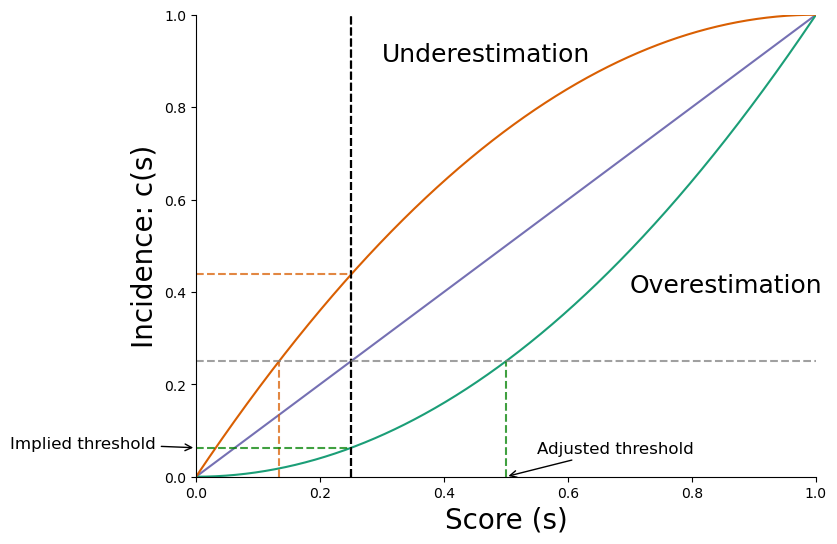

In [12]:
wspace=0.5
threshold=0.25
plt.close()

fig=plt.figure(figsize=(8,6))
ax=plt.gca()
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=ax,
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
    threshold=threshold,
)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=ax,
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
    threshold=threshold,
)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=ax,
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
    threshold=threshold,
)

implicit_threshold_over=parameters['A_over']['calibration_curve'][
    np.abs(parameters['A_over']['x'] - threshold).argmin()
]
implicit_threshold_under=parameters['A_under']['calibration_curve'][
    np.abs(parameters['A_under']['x'] - threshold).argmin()
]
adjusted_threshold_over=parameters['A_over']['x'][
    np.abs(parameters['A_over']['calibration_curve'] - threshold).argmin()
]
adjusted_threshold_under=parameters['A_under']['x'][
    np.abs(parameters['A_under']['calibration_curve'] - threshold).argmin()
]
ax.axhline(
    implicit_threshold_under, 
    xmax=threshold, 
    linestyle='--', 
    color=colors['cb_orange'], 
    alpha=0.75
)
ax.axvline(
    adjusted_threshold_under, 
    ymax=threshold, 
    linestyle='--', 
    color=colors['cb_orange'], 
    alpha=0.75,
)
ax.axhline(
    implicit_threshold_over, 
    xmax=threshold, 
    linestyle='--', 
    color='g', 
    alpha=0.75
)
ax.axvline(
    adjusted_threshold_over, 
    ymax=threshold, 
    linestyle='--', 
    color='g', 
    alpha=0.75,
)
ax.axhline(
    threshold, 
    linestyle='--', 
    color='gray', 
    alpha=0.75
)
ax.set_xlabel('Score (s)', fontsize=20)
ax.set_ylabel('Incidence: c(s)', fontsize=20)
ax.text(0.7, 0.4, 'Overestimation', fontsize=18)
ax.text(0.3, 0.9, 'Underestimation', fontsize=18)
ax.annotate('Adjusted threshold', xy=(adjusted_threshold_over, 0), xytext=(0.55, 0.05), arrowprops={'arrowstyle': '->'}, fontsize=12)
ax.annotate('Implied threshold', xy=(0, implicit_threshold_over), xytext=(-0.3, implicit_threshold_over), arrowprops={'arrowstyle': '->'}, fontsize=12)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'calibration_curve_2.png'), dpi=300, bbox_inches="tight")


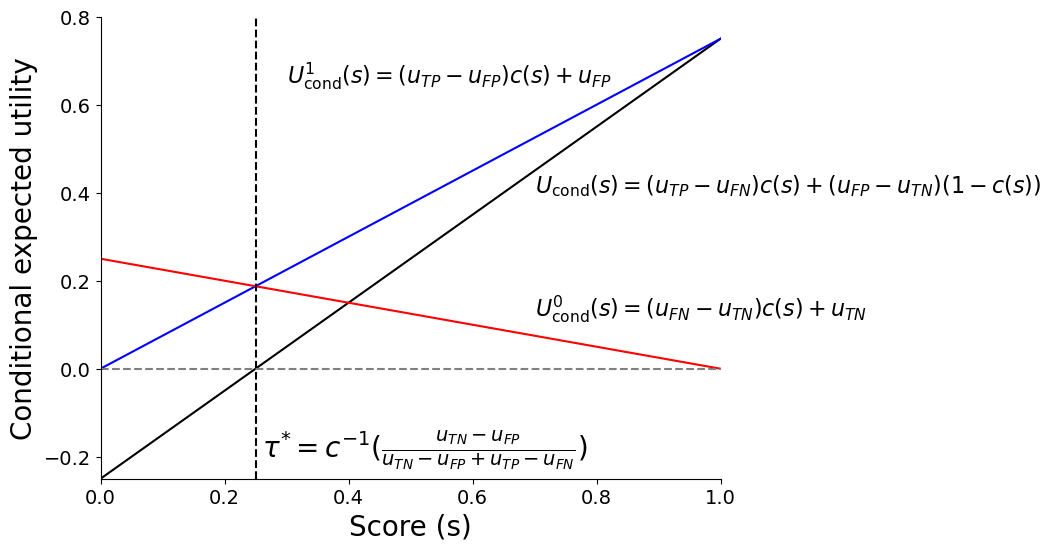

In [13]:
plt.close()
fig=plt.figure(figsize=(8,6))
ax=plt.gca()

plt.plot(parameters['A']['x'], parameters['A']['conditional_utility'], 'k')
plt.plot(parameters['A']['x'], parameters['A']['u_treat'], 'b')
plt.plot(parameters['A']['x'], parameters['A']['u_no_treat'], color='r')

plt.axvline(threshold, linestyle='--', color='k')
plt.axhline(0, linestyle='--', color='gray')


ax.set_xlabel('Score (s)', fontsize=20)
ax.set_ylabel('Conditional expected utility', fontsize=20)
ax.set_xlim(0, 1)
ax.set_ylim(-.25, 0.8)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.text(0.7, 0.12, r'$U_{\mathrm{cond}}^0(s)=(u_{FN}-u_{TN}) c(s) + u_{TN}$', fontsize=16)
ax.text(0.3, 0.65, r'$U_{\mathrm{cond}}^1(s)=(u_{TP}-u_{FP}) c(s) + u_{FP}$', fontsize=16)
ax.text(0.7, 0.4, r'$U_{\mathrm{cond}}(s)=(u_{TP}-u_{FN}) c(s) + (u_{FP}-u_{TN})(1-c(s))$', fontsize=16)
ax.text(0.26, -0.2, r'$\tau^{*}=c^{-1}(\frac{u_{TN}-u_{FP}}{u_{TN}-u_{FP} + u_{TP}-u_{FN}})$', fontsize=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'fixed_cost_utility_fn.png'), dpi=300, bbox_inches="tight")

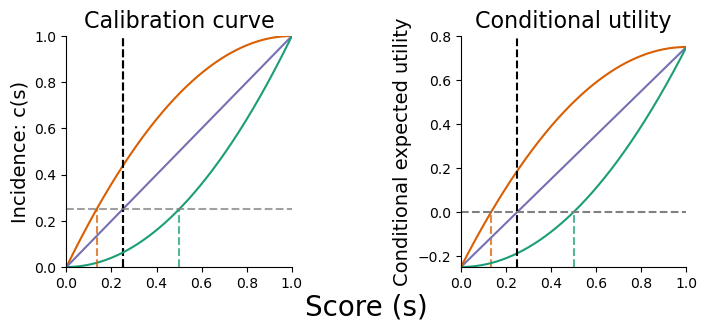

In [14]:
plt.close()
figsize=(8,3)
fig, axes = plt.subplots(1, 2, figsize=figsize, squeeze=False)
plt.subplots_adjust(wspace=0.75)

## Conditional utility
axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(-.25, 0.8)
axes[0,1].plot(parameters['A']['x'], get_conditional_utility(parameters['A']['calibration_curve']), colors['cb_purple'])
axes[0,1].plot(parameters['A_under']['x'], get_conditional_utility(parameters['A_under']['calibration_curve']), color=colors['cb_orange'])
axes[0,1].plot(parameters['A_over']['x'], get_conditional_utility(parameters['A_over']['calibration_curve']), color=colors['cb_green'])
axes[0,1].axvline(threshold, linestyle='--', color='k')
axes[0,1].axhline(0, linestyle='--', color='gray')
axes[0,1].vlines(
    adjusted_threshold_under, 
    ymin=-0.25,
    ymax=0, 
    linestyle='--', 
    color=colors['cb_orange'], 
    alpha=0.75,
)
axes[0,1].vlines(
    adjusted_threshold_over, 
    ymin=-0.25,
    ymax=0, 
    linestyle='--', 
    color=colors['cb_green'], 
    alpha=0.75,
)

axes[0,1].set_ylabel('Conditional expected utility', fontsize=14)
axes[0,1].set_title('Conditional utility', fontsize=16)

## Calibration curves
axes[0,0].set_ylim(0, 1)
axes[0,0].set_xlim(0, 1)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,0],
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
    threshold=threshold,
)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,0],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
    threshold=threshold,
)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,0],
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
axes[0,0].axhline(
    threshold, 
    linestyle='--', 
    color='gray', 
    alpha=0.75
)
axes[0,0].axvline(
    adjusted_threshold_under, 
    ymax=threshold, 
    linestyle='--', 
    color=colors['cb_orange'], 
    alpha=0.75,
)
axes[0,0].axvline(
    adjusted_threshold_over, 
    ymax=threshold, 
    linestyle='--', 
    color=colors['cb_green'], 
    alpha=0.75,
)
axes[0,0].set_ylabel('Incidence: c(s)', fontsize=14)
axes[0,0].set_title('Calibration curve', fontsize=16)

fig.text(0.5, -0.05, 'Score (s)', ha='center', size=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'calibration_utility_2.png'), dpi=300, bbox_inches="tight")

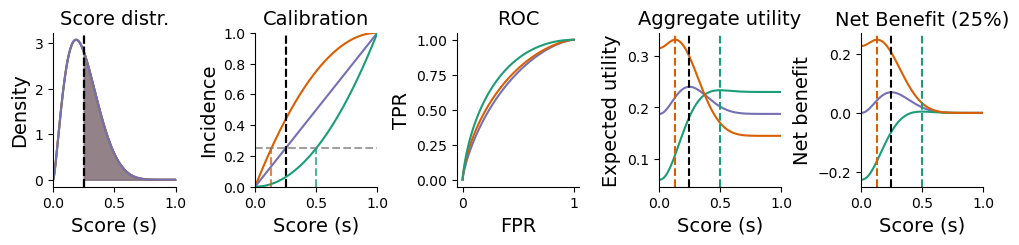

In [15]:
plt.close()
figsize=(12,2)
fig, axes = plt.subplots(1, 5, figsize=figsize, squeeze=False)
plt.subplots_adjust(wspace=0.65)

# Plot 0 - Density

plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    groups=['A_under'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_green']
)
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    groups=['A_over'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_orange']
)
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_purple']
)
axes[0,0].set_ylabel('Density', fontsize=14)
axes[0,0].set_title('Score distr.', fontsize=14)
axes[0,0].set_xlabel('Score (s)', fontsize=14)

# Plot 1 - Calibration
axes[0,1].set_ylim(0, 1)
axes[0,1].set_xlim(0, 1)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,1],
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
    threshold=threshold,
)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,1],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
    threshold=threshold,
)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,1],
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
axes[0,1].axhline(
    threshold, 
    linestyle='--', 
    color='gray', 
    alpha=0.75
)
axes[0,1].axvline(
    adjusted_threshold_under, 
    ymax=threshold, 
    linestyle='--', 
    color=colors['cb_orange'], 
    alpha=0.75,
)
axes[0,1].axvline(
    adjusted_threshold_over, 
    ymax=threshold, 
    linestyle='--', 
    color=colors['cb_green'], 
    alpha=0.75,
)
axes[0,1].set_ylabel('Incidence', fontsize=14)
axes[0,1].set_title('Calibration', fontsize=14)
axes[0,1].set_xlabel('Score (s)', fontsize=14)

## ROC

axes[0,2].plot(parameters['A']['FPR'], parameters['A']['TPR'], color=colors['cb_purple'])
axes[0,2].plot(parameters['A_under_recalib']['FPR'], parameters['A_under_recalib']['TPR'], color=colors['cb_orange'])
axes[0,2].plot(parameters['A_over_recalib']['FPR'], parameters['A_over_recalib']['TPR'], color=colors['cb_green'])
axes[0,2].set_ylabel('TPR', fontsize=14)
axes[0,2].set_xlabel('FPR', fontsize=14)
axes[0,2].set_title('ROC', fontsize=14)

## Aggregate utility
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[0,3],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[0,3],
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[0,3],
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)
axes[0,3].axvline(threshold, linestyle='--', color='k')
axes[0,3].axvline(adjusted_threshold_over, linestyle='--', color=colors['cb_green'])
axes[0,3].axvline(adjusted_threshold_under, linestyle='--', color=colors['cb_orange'])
axes[0,3].set_ylabel('Expected utility', fontsize=14)
axes[0,3].set_title(r'Aggregate utility', fontsize=14)
axes[0,3].set_xlabel('Score (s)', fontsize=14)

## Net benefit - fixed
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)
axes[0,4].set_ylabel('Net benefit', fontsize=14)
axes[0,4].set_title(r'Net Benefit (25%)', fontsize=14)
axes[0,4].axvline(threshold, linestyle='--', color='k')
axes[0,4].axvline(adjusted_threshold_over, linestyle='--', color=colors['cb_green'])
axes[0,4].axvline(adjusted_threshold_under, linestyle='--', color=colors['cb_orange'])
axes[0,4].set_xlabel('Score (s)', fontsize=14)


sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'distr_calib_utility.png'), dpi=300, bbox_inches="tight")

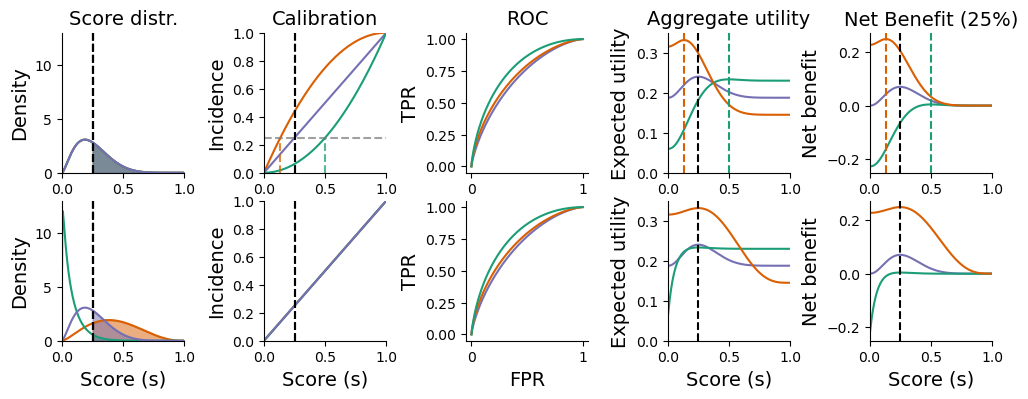

In [16]:
plt.close()
figsize=(12,4)
fig, axes = plt.subplots(2, 5, figsize=figsize, squeeze=False)
plt.subplots_adjust(wspace=0.65)

# Plot 0 - Density

plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    groups=['A_under'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_orange']
)
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    groups=['A_over'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_green']
)
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_purple']
)
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[1, 0], 
    groups=['A_under_recalib'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_orange']
)
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[1, 0], 
    groups=['A_over_recalib'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_green']
)
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[1, 0], 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_purple']
)

axes[0,0].set_ylabel('Density', fontsize=14)
axes[1,0].set_ylabel('Density', fontsize=14)
axes[0,0].set_title('Score distr.', fontsize=14)
axes[1,0].set_xlabel('Score (s)', fontsize=14)
axes[0,0].set_ylim(0, 13)
axes[1,0].set_ylim(0, 13)



# Calibration
axes[0,1].set_ylim(0, 1)
axes[0,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].set_xlim(0, 1)

# Upper plot
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,1],
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
    threshold=threshold,
)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,1],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
    threshold=threshold,
)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,1],
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
axes[0,1].axhline(
    threshold, 
    linestyle='--', 
    color='gray', 
    alpha=0.75
)
axes[0,1].axvline(
    adjusted_threshold_under, 
    ymax=threshold, 
    linestyle='--', 
    color=colors['cb_orange'], 
    alpha=0.75,
)
axes[0,1].axvline(
    adjusted_threshold_over, 
    ymax=threshold, 
    linestyle='--', 
    color=colors['cb_green'], 
    alpha=0.75,
)

# Lower plot
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[1,1],
    groups=['A_under_recalib'],
    color_override=colors['cb_orange'],
    apply_fill=False,
    threshold=threshold,
)


plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[1,1],
    groups=['A_over_recalib'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[1,1],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
    threshold=threshold,
)
axes[0,1].set_ylabel('Incidence', fontsize=14)
axes[1,1].set_ylabel('Incidence', fontsize=14)

axes[0,1].set_title('Calibration', fontsize=14)
axes[1,1].set_xlabel('Score (s)', fontsize=14)



## ROC
axes[0,2].plot(parameters['A']['FPR'], parameters['A']['TPR'], color=colors['cb_purple'])
axes[0,2].plot(parameters['A_under']['FPR'], parameters['A_under']['TPR'], color=colors['cb_orange'])
axes[0,2].plot(parameters['A_over']['FPR'], parameters['A_over']['TPR'], color=colors['cb_green'])

axes[1,2].plot(parameters['A']['FPR'], parameters['A']['TPR'], color=colors['cb_purple'])
axes[1,2].plot(parameters['A_under_recalib']['FPR'], parameters['A_under_recalib']['TPR'], color=colors['cb_orange'])
axes[1,2].plot(parameters['A_over_recalib']['FPR'], parameters['A_over_recalib']['TPR'], color=colors['cb_green'])

axes[0,2].set_ylabel('TPR', fontsize=14)
axes[1,2].set_ylabel('TPR', fontsize=14)
axes[1,2].set_xlabel('FPR', fontsize=14)
axes[0,2].set_title('ROC', fontsize=14)


## Aggregate utility
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[0,3],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[0,3],
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[0,3],
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)
axes[0,3].axvline(threshold, linestyle='--', color='k')
axes[0,3].axvline(adjusted_threshold_over, linestyle='--', color=colors['cb_green'])
axes[0,3].axvline(adjusted_threshold_under, linestyle='--', color=colors['cb_orange'])

plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[1,3],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[1,3],
    groups=['A_over_recalib'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='u_agg',
    ax=axes[1,3],
    groups=['A_under_recalib'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)

axes[0, 3].set_ylim(0, 0.35)
axes[1, 3].set_ylim(0, 0.35)
axes[1,3].axvline(threshold, linestyle='--', color='k')

axes[0,3].set_ylabel('Expected utility', fontsize=14)
axes[1,3].set_ylabel('Expected utility', fontsize=14)

axes[0,3].set_title(r'Aggregate utility', fontsize=14)
axes[1,3].set_xlabel('Score (s)', fontsize=14)

## Net benefit - fixed
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_over'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_under'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)

plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[1,4],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[1,4],
    groups=['A_over_recalib'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[1,4],
    groups=['A_under_recalib'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)


axes[0,4].set_ylabel('Net benefit', fontsize=14)
axes[1,4].set_ylabel('Net benefit', fontsize=14)
axes[0,4].set_title(r'Net Benefit (25%)', fontsize=14)
axes[0,4].axvline(threshold, linestyle='--', color='k')
axes[0,4].axvline(adjusted_threshold_over, linestyle='--', color=colors['cb_green'])
axes[0,4].axvline(adjusted_threshold_under, linestyle='--', color=colors['cb_orange'])
axes[1,4].axvline(threshold, linestyle='--', color='k')
axes[1,4].set_xlabel('Score (s)', fontsize=14)

fig.align_ylabels(axes[:, 0])
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'distr_calib_utility_recalib.png'), dpi=300, bbox_inches="tight")

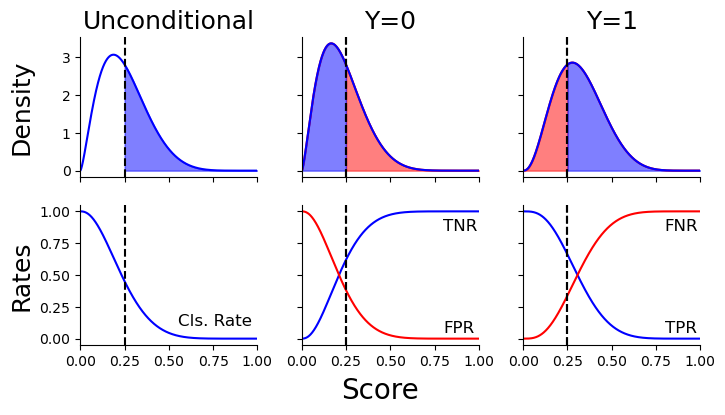

In [17]:
figsize=(8,4)
wspace=0.5
threshold=0.25
plt.close()
fig, axes = plt.subplots(2, 3, figsize=figsize, squeeze=False, sharey='row', sharex=True)
plt.subplots_adjust(wspace=0.25)

## Unconditional ##
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    title='Unconditional', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override='b'
)
axes[0, 0].set_ylabel('Density', fontsize=18)
plot_distributions(
    parameters, 
    plot_y='classification_rate', 
    ax=axes[1, 0],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='b'
)
axes[1, 0].set_ylabel('Rates', fontsize=18)
axes[1, 0].text(0.55, 0.1, 'Cls. Rate', fontsize=12)

## Y = 0
plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
#     title='Y=0', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override='r'
)
plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
    title='Y=0', 
    groups='A', 
    fill_min=0, 
    fill_max=threshold,
    threshold=threshold,
    color_override='b'
)
plot_distributions(
    parameters, 
    plot_y='TNR', 
    ax=axes[1, 1],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='b'
)
plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[1, 1],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='r'
)
axes[1,1].text(0.8, 0.85, 'TNR', fontsize=12)
axes[1,1].text(0.8, 0.05, 'FPR', fontsize=12)

## Y = 1
plot_distributions(
    parameters, 
    plot_y='pdf_1', 
    ax=axes[0, 2], 
#     title='Y=1', 
    groups='A', 
    fill_min=0, 
    fill_max=threshold,
    threshold=threshold,
    color_override='r'
)
plot_distributions(
    parameters, 
    plot_y='pdf_1', 
    ax=axes[0, 2], 
    title='Y=1', 
    groups='A', 
    fill_min=threshold, 
#     fill_max=threshold,
    threshold=threshold,
    color_override='b'
)

plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[1, 2],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='b'
)
plot_distributions(
    parameters, 
    plot_y='FNR', 
    ax=axes[1, 2],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override='r'
)
axes[1,2].text(0.8, 0.85, 'FNR', fontsize=12)
axes[1,2].text(0.8, 0.05, 'TPR', fontsize=12)
fig.align_ylabels(axes[:, 0])
fig.text(0.5, -0.025, 'Score', ha='center', size=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'distribution_plots_tpr_fpr.png'), dpi=300, bbox_inches="tight")

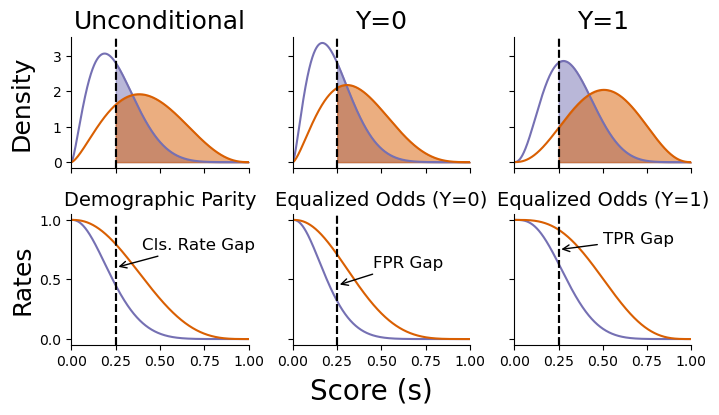

In [18]:
figsize=(8,4)
threshold=0.25
plt.close()
fig, axes = plt.subplots(2, 3, figsize=figsize, squeeze=False, sharey='row', sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.35)

## Unconditional ##
plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    title='Unconditional', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_purple']
)
axes[0, 0].set_ylabel('Density', fontsize=18)
plot_distributions(
    parameters, 
    plot_y='classification_rate', 
    ax=axes[1, 0],
    groups='A', 
    apply_fill=False,
    threshold=threshold,
    color_override=colors['cb_purple']
)

plot_distributions(
    parameters, 
    plot_y='pdf', 
    ax=axes[0, 0], 
    title='Unconditional', 
    groups=['A_under_recalib'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_orange']
)
axes[0, 0].set_ylabel('Density', fontsize=18)

plot_distributions(
    parameters, 
    plot_y='classification_rate', 
    ax=axes[1, 0],
    groups=['A_under_recalib'], 
    apply_fill=False,
    threshold=threshold,
    color_override=colors['cb_orange']
)

axes[1, 0].set_ylabel('Rates', fontsize=18)
axes[1, 0].annotate('Cls. Rate Gap', xy=(0.25, 0.6), xytext=(0.4, 0.75), arrowprops={'arrowstyle': '->'}, fontsize=12)
axes[1, 0].set_title('Demographic Parity', fontsize=14)


## Y = 0
plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
    title='Y=0', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_purple']
)

plot_distributions(
    parameters, 
    plot_y='pdf_0', 
    ax=axes[0, 1], 
    title='Y=0', 
    groups=['A_under_recalib'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_orange']
)

plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[1, 1],
    groups=['A_under'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_purple']
)

plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[1, 1],
    groups=['A_under_recalib'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_orange']
)
axes[1, 1].annotate('FPR Gap', xy=(0.25, 0.45), xytext=(0.45, 0.6), arrowprops={'arrowstyle': '->'}, fontsize=12)
axes[1, 1].set_title('Equalized Odds (Y=0)', fontsize=14)


## Y = 1
plot_distributions(
    parameters, 
    plot_y='pdf_1', 
    ax=axes[0, 2], 
    title='Y=1', 
    groups='A', 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_purple']
)

plot_distributions(
    parameters, 
    plot_y='pdf_1', 
    ax=axes[0, 2], 
    title='Y=1', 
    groups=['A_under_recalib'], 
    fill_min=threshold, 
    threshold=threshold,
    color_override=colors['cb_orange']
)

plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[1, 2],
    groups=['A_under'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_purple']
)

plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[1, 2],
    groups=['A_under_recalib'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_orange']
)
axes[1, 2].annotate('TPR Gap', xy=(0.25, 0.75), xytext=(0.5, 0.8), arrowprops={'arrowstyle': '->'}, fontsize=12)
axes[1, 2].set_title('Equalized Odds (Y=1)', fontsize=14)

## Plot figure
fig.align_ylabels(axes[:, 0])
fig.text(0.5, -0.025, 'Score (s)', ha='center', size=20)
sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'two_groups_distribution_plots_demparity_eqodds.png'), dpi=300, bbox_inches="tight")

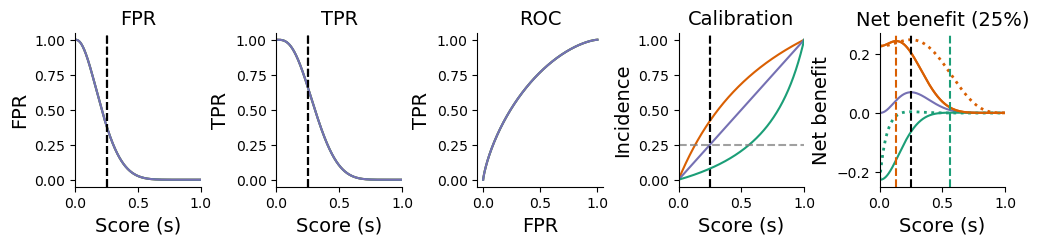

In [19]:
figsize=(12,2)
threshold=0.25
plt.close()
fig, axes = plt.subplots(1, 5, figsize=figsize, squeeze=False)
plt.subplots_adjust(wspace=0.6, hspace=0.35)

## FPR
plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[0,0],
    groups=['A_under_recalib_eq'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_orange']
)
plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[0,0],
    groups=['A_over_recalib_eq'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_green']
)
plot_distributions(
    parameters, 
    plot_y='FPR', 
    ax=axes[0,0],
    groups=['A'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_purple']
)
axes[0,0].set_ylabel('FPR', fontsize=14)
axes[0,0].set_title('FPR', fontsize=14)
axes[0,0].set_xlabel('Score (s)', fontsize=14)

## TPR
plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[0,1],
    groups=['A_under_recalib_eq'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_orange']
)
plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[0,1],
    groups=['A_over_recalib_eq'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_green']
)
plot_distributions(
    parameters, 
    plot_y='TPR', 
    ax=axes[0,1],
    groups=['A'], 
    fill_min=threshold,
    threshold=threshold,
    apply_fill=False,
    color_override=colors['cb_purple']
)

adjusted_threshold_over_recalib_eq=parameters['A_over']['x'][
    np.abs(parameters['A_over_recalib_eq']['calibration_curve'] - threshold).argmin()
]
adjusted_threshold_under_recalib_eq=parameters['A_under']['x'][
    np.abs(parameters['A_under_recalib_eq']['calibration_curve'] - threshold).argmin()
]
axes[0,1].set_ylabel('TPR', fontsize=14)
axes[0,1].set_title('TPR', fontsize=14)
axes[0,1].set_xlabel('Score (s)', fontsize=14)

## ROC

axes[0,2].plot(parameters['A_under_recalib_eq']['FPR'], parameters['A_under_recalib_eq']['TPR'], color=colors['cb_orange'])
axes[0,2].plot(parameters['A_over_recalib_eq']['FPR'], parameters['A_over_recalib_eq']['TPR'], color=colors['cb_green'])
axes[0,2].plot(parameters['A']['FPR'], parameters['A']['TPR'], color=colors['cb_purple'])

axes[0,2].set_ylabel('TPR', fontsize=14)
axes[0,2].set_xlabel('FPR', fontsize=14)
axes[0,2].set_title('ROC', fontsize=14)


## Calibration
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,3],
    groups=['A_under_recalib_eq'],
    color_override=colors['cb_orange'],
    apply_fill=False,
    threshold=threshold,
)
plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,3],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
    threshold=threshold,
)

plot_distributions(
    parameters,
    plot_y='calibration_curve',
    ax=axes[0,3],
    groups=['A_over_recalib_eq'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
axes[0,3].axhline(
    threshold, 
    linestyle='--', 
    color='gray', 
    alpha=0.75
)
axes[0,3].set_ylabel('Incidence', fontsize=14)
axes[0,3].set_title('Calibration', fontsize=14)
axes[0,3].set_xlabel('Score (s)', fontsize=14)

## Net benefit
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A'],
    color_override=colors['cb_purple'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_over_recalib_eq'],
    color_override=colors['cb_green'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_under_recalib_eq'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_over_recalib'],
    color_override=colors['cb_green'],
    apply_fill=False,
    linestyle='dotted',
    lw=2
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_under_recalib_eq'],
    color_override=colors['cb_orange'],
    apply_fill=False,
)
plot_distributions(
    parameters,
    plot_y='nb_fixed',
    ax=axes[0,4],
    groups=['A_under_recalib'],
    color_override=colors['cb_orange'],
    apply_fill=False,
    linestyle='dotted',
    lw=2
)
axes[0,4].axvline(threshold, linestyle='--', color='k')
axes[0,4].axvline(adjusted_threshold_over_recalib_eq, linestyle='--', color=colors['cb_green'])
axes[0,4].axvline(adjusted_threshold_under_recalib_eq, linestyle='--', color=colors['cb_orange'])
axes[0,4].set_ylabel('Net benefit', fontsize=14)
axes[0,4].set_title('Net benefit (25%)', fontsize=14)
axes[0,4].set_xlabel('Score (s)', fontsize=14)

sns.despine()
plt.show()
fig.savefig(os.path.join(figure_path, 'equal_odds_net_benefit.png'), dpi=300, bbox_inches="tight")